In [160]:
import pandas as pd
import numpy as np

import datetime
import matplotlib.pyplot as plt
from matplotlib.dates import WeekdayLocator
from matplotlib.dates import MO, TU, WE, TH, FR, SA, SU
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

class Opinion:
    
    @classmethod
    def getDataByDateRange(self, data, fromDate, toDate):
        data = data[( pd.to_datetime(data['date']) >= fromDate) & ( pd.to_datetime(data['date']) <= toDate) ]
        return data
    
    @classmethod
    def orderData(self, data, by, tureOrFalse=True):
        #by : Name or list of names which refer to the axis items
        #Ascending by default
        data = data.sort_values(by, ascending=tureOrFalse)
        return data
        
    @classmethod
    def vaderCategorize(self, data):
        #categorizing based on value ranges given in paper
        values = pd.cut(data["VADER"], bins=[-1.1, -0.61, -0.21, 0.19, 0.59,1], 
                    labels=["very nagative","negative","neutral", "positive", "very positive"] )
        #create new column category and assign values
        data["category"] = str('')
        data["category"] = values
        return data
        
    @classmethod
    def getCommentsByCat(self, data, cat):   
        #get only positive rows
        data = data.loc[data["category"] == cat]
        return data
    
    @classmethod
    def groupBy(self, data, col, operation="sum"):   
        #get only positive rows
        if(operation == "sum"):
            data = data.groupby([col], sort=False).sum().reset_index()
        if(operation == "mean"):
            data = data.groupby([col], sort=False).mean().reset_index()
            
        if(operation == "count"):
            data = data.groupby([col], sort=False).count().reset_index()
        
        return data
    
    @classmethod
    def zscore(self, data, cols):
        for col in cols:
            col_zscore = 'zscore_'+col
            zscore = (data[col] - data[col].mean()) / data[col].std(ddof=0)         
        return zscore
    
    @classmethod
    def plotData(cls, x, y, colour, x1='', y1='', colour1=''):
        fig, ax = plt.subplots(figsize=(15, 7))
        if len(x1) > 1:
            ax.plot_date(x, y,  fmt=colour)
            ax.plot_date(x1, y1,  fmt=colour1)
        else:
            ax.plot_date(x, y,  fmt=colour)
            
        
        fig.autofmt_xdate()
        # For tickmarks and ticklabels every week
        ax.xaxis.set_major_locator(WeekdayLocator(byweekday=MO))
        # For tickmarks and ticklabels every other week
        ax.xaxis.set_major_locator(WeekdayLocator(byweekday=MO, interval=1))

        plt.grid(True)
        plt.show()

opinion = Opinion()

In [2]:
print('loading') 
# load replies data
def dateparse(x):
    datetime.datetime.strptime(x, "%m/%d/%Y").strftime('%Y-%m-%d')

replies = pd.read_excel('bitcoin-data/bitcoin_reply_xl.xlsx', 'bitcoin_reply_xl', parse_dates = ['date'], dayfirst=True)
replies.describe()

loading


,VADER
count,396675.000000
mean,0.190674
std,0.531326
min,-0.999800
25%,-0.150100
50%,0.232500
75%,0.659000
max,0.999900


In [3]:
# load topics data
print('reading')
topics = pd.read_excel('bitcoin-data/bitcoin_topic.xlsx', 'bitcoin_topic', parse_dates = ['date'], dayfirst=True)
topics.describe()

reading


,reply,views,VADER,Opinion
count,13759.000000,13759.000000,13759.000000,13759.000000
mean,28.959881,2075.020060,0.318256,0.060179
std,90.071997,9111.454448,0.581903,0.237826
min,0.000000,15.000000,-0.999800,0.000000
25%,3.000000,487.000000,0.000000,0.000000
50%,12.000000,847.000000,0.451500,0.000000
75%,30.000000,1707.500000,0.854000,0.000000
max,4539.000000,457505.000000,0.999900,1.000000


In [144]:
# bitcoin price data
btcPrice = pd.read_excel('bitcoin-data/bitcoin_price.xlsx', 'bitcoin_price', parse_dates = ['date'], dayfirst=True)
btcPrice = Opinion.getDataByDateRange(btcPrice, '2013-12-1', '2016-2-1')
btcPrice.describe()

,close_price
count,793.000000
mean,415.651576
std,184.711612
min,177.280000
25%,254.520000
50%,373.490000
75%,525.630000
max,1147.250000


In [145]:
#order data, by, true=asc, false=desc
replies = Opinion.orderData(replies, 'date', bool(0))
topics = Opinion.orderData(topics, 'date', bool(0))
btcPrice = Opinion.orderData(btcPrice, 'date', bool(0))

# Computing number of topics and number of replies 

In [118]:
#number of topics 
topicCount = Opinion.groupBy(topics, 'date', "count")
numTopics = pd.DataFrame(topicCount[['date', 'topic']])

#number of replies
repliesCount = Opinion.groupBy(replies, 'date', "count")
numReplies = pd.DataFrame(repliesCount[['date', 'reply']])

#inner join on date to remove descrepencies
numTopicsReplies = pd.merge(numTopics, numReplies, how='inner', on='date')
numTopicsReplies.shape

(1139, 3)

# Labeling replies from very negative to very possitive

In [120]:
#five categories 
#labeling replies i.e very negative to very positive
replies = Opinion.vaderCategorize(replies)

#get comment by category, i.e very positive to very negative
# Positive replies has more coorelation with bitcoin price data
filteredreplies = Opinion.getCommentsByCat(replies, 'positive')

#summing vader of replies by date
summedreplies = Opinion.groupBy(filteredreplies, 'date', 'sum')
summedreplies.shape


(1667, 2)

# Merging Topics, number of replies and positive replies

In [146]:
#inner join on date to remove descrepencies
sentiments = pd.merge(numTopicsReplies, summedreplies, how='inner', on='date')
sentiments.shape

(1115, 4)

# Merging Topics, number of replies, positvie replies and Bitcoin Price

In [149]:
dataset = pd.merge(btcPrice, sentiments, how='inner', on='date')
dataset.head(3)

,date,close_price,topic,reply,VADER
0,2016-02-01,371.25,19,931,89.5349
1,2016-01-31,367.13,10,780,80.3750
2,2016-01-30,376.94,7,900,89.5305


In [157]:
dataset.to_csv('bitcoin-data/dataset.csv')

# Visualizing dataset

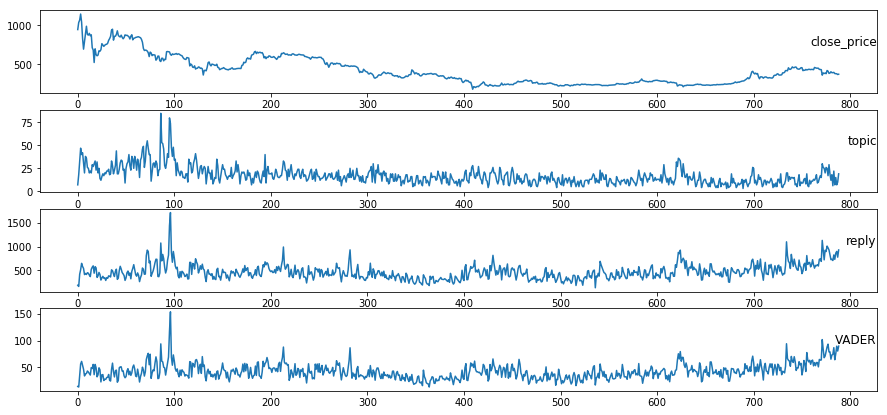

In [150]:
#Visualizing dataset
dataset = Opinion.orderData(dataset, 'date')
values = dataset.values
# specify columns to plot
groups = [1, 2, 3, 4]
i = 1
# plot each column
fig, ax = plt.subplots(figsize=(15, 7))
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(dataset.columns[group], y=0.5, loc='right')
    i += 1
    
plt.show()


# Making data ready for LSTM

In [204]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
# load dataset
dataset = pd.read_csv('bitcoin-data/dataset.csv', header=0, index_col=0)
dataset.drop('date', axis=1, inplace=True)
values = dataset.values
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 2, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[9,10,11]], axis=1, inplace=True)
print(reframed.head())

   var1(t-2)  var2(t-2)  var3(t-2)  var4(t-2)  var1(t-1)  var2(t-1)  \
2   0.793468   0.048780   0.033566   0.007646   0.887728   0.182927   
3   0.887728   0.182927   0.017733   0.000000   0.918987   0.365854   
4   0.918987   0.365854   0.179227   0.157974   1.000000   0.536585   
5   1.000000   0.536585   0.240025   0.306284   0.891522   0.451219   
6   0.891522   0.451219   0.324889   0.340973   0.677083   0.475610   

   var3(t-1)  var4(t-1)   var1(t)  
2   0.017733   0.000000  0.918987  
3   0.179227   0.157974  1.000000  
4   0.240025   0.306284  0.891522  
5   0.324889   0.340973  0.677083  
6   0.283091   0.287945  0.533202  


# Splitting Data into Training and Testing Dataset

In [205]:
# split into train and test sets
# split into train and test sets
values = reframed.values
n_train_hours = 600
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(600, 1, 8) (600,) (187, 1, 8) (187,)


Train on 600 samples, validate on 187 samples
Epoch 1/10
8s - loss: 0.2119 - val_loss: 0.0658
Epoch 2/10
9s - loss: 0.1722 - val_loss: 0.0601
Epoch 3/10
10s - loss: 0.1398 - val_loss: 0.0688
Epoch 4/10
9s - loss: 0.1207 - val_loss: 0.0710
Epoch 5/10
9s - loss: 0.1066 - val_loss: 0.0651
Epoch 6/10
9s - loss: 0.0946 - val_loss: 0.0555
Epoch 7/10
10s - loss: 0.0839 - val_loss: 0.0461
Epoch 8/10
11s - loss: 0.0729 - val_loss: 0.0371
Epoch 9/10
9s - loss: 0.0612 - val_loss: 0.0290
Epoch 10/10
9s - loss: 0.0496 - val_loss: 0.0253


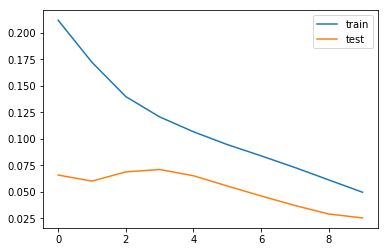

In [206]:
# design network
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

model = Sequential()
model.add(LSTM(8, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=10, batch_size=10, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [207]:
# make a prediction
import math
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, 1:]), axis=1)
#inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y =  np.concatenate((test_y, test_X[:, 1:]), axis=1)
#inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = math.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.034


In [212]:
yhat

array([ 0.11246573,  0.10332301,  0.10905784,  0.10711971,  0.11740129,
        0.10322995,  0.13235635,  0.15980639,  0.12448315,  0.09969108,
        0.08613125,  0.083088  ,  0.07512865,  0.09181018,  0.09973787,
        0.08552298,  0.0804324 ,  0.07492468,  0.08662973,  0.10630303,
        0.1376261 ,  0.12813386,  0.16214976,  0.15182927,  0.14847055,
        0.1091622 ,  0.09659835,  0.12312502,  0.09313859,  0.08089145,
        0.08939627,  0.08688488,  0.05320856,  0.08017584,  0.07864258,
        0.0717289 ,  0.07193949,  0.07799657,  0.0943552 ,  0.07009327,
        0.05416594,  0.06313525,  0.07104727,  0.08295487,  0.1105317 ,
        0.08052129,  0.03480294,  0.05023734,  0.06637099,  0.07277733,
        0.07272814,  0.06677532,  0.05200107,  0.04822283,  0.05463149,
        0.06350963,  0.08522269,  0.06910648,  0.07274291,  0.06182759,
        0.05200939,  0.05396783,  0.05135495,  0.05160884,  0.07258134,
        0.07046527,  0.05720729,  0.05773459,  0.05747161,  0.06